**# 权重衰退**

* 权重衰退是最广泛使用的正则化的技术之一

In [ ]:
!pip install d2l
!pip install matplotlib==3.0

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

* **生成数据集**

* 生成公式如下：

**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**
* 选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，并使用一个只包含20个样本的小训练集。

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

# Weight-Decay从零开始实现

**1. 初始化参数模型**

In [ ]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

**2. 定义$L_2$范数惩罚**

In [ ]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

**3. 定义训练代码实现**

In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss  
    # lambda X...表示输入是X，输出是d2l.linreg(X, w, b)
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

**4. 忽略正则化直接训练**

* 现在用`lambd = 0`禁用权重衰减后运行这个代码。注意，这里训练误差有了减少，但测试误差没有减少，这意味着出现了严重的过拟合。

w的L2范数是： 12.765652656555176


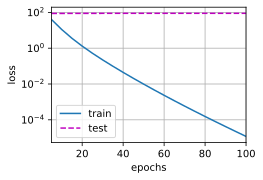

In [ ]:
train(lambd=0)

**5. 使用权重衰退**

w的L2范数是： 0.3693276643753052


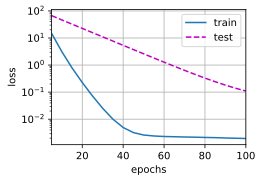

In [ ]:
train(lambd=3)

# Weight-Decay的简洁实现

* 在下面的代码中，在实例化优化器时直接通过`weight_decay`指定weight decay超参数。默认情况下，PyTorch同时衰减权重和偏移。这里只为权重设置了`weight_decay`，所以偏置参数$b$不会衰减。

In [ ]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.494709014892578


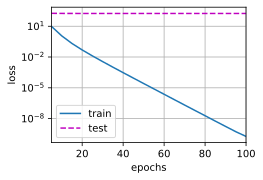

In [ ]:
train_concise(0)

w的L2范数： 0.524336576461792


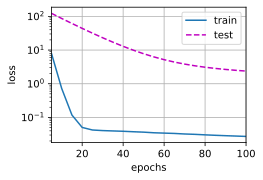

In [ ]:
train_concise(3)